In [1]:
from ce3_compare import set_name, compare, write_submission_txt, grade, set_idm
from feature_model import FeatureModel
import numpy as np

In [2]:
set_name("Sujit", "Debnath")
set_idm("ve75wiwa")

# Computer Exercise 3 (Global post-hoc methods)

- Partial dependence plots (PDP)
- Individual conditional expectation (ICE) <- *local*
- M-Plot
- Accumulated local effects (ALE)
- Permutation feature importance

<img src="pdp_ice_mplot_ale.png" width="1200"/>

## Partial dependence plots (PDP)

In [3]:
bike_path = "datasets/bike/rented_bikes_day_pre.csv"
bike_data = FeatureModel(bike_path)
bike_data.df = bike_data.df.drop(labels=["casual", "registered"], axis=1)
bike_data.add_target("cnt")
bike_data.add_all_features_but_target()

FeatureModel(->Not fully specified yet!)
FeatureModel(cnt ~ -1 + season + yr + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed + days_since_01_01_2011 )


In [4]:
X,y = bike_data.return_Xy(train_test_split=False)

In [5]:
from sklearn.inspection import PartialDependenceDisplay

def pdp_plot(m, X_train, y_train, X_val=None, kind="average", features=["temp","hum","windspeed"]):
    if X_val is None:
        X_val = X_train
        
    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind=kind, grid_resolution=100, percentiles=(0,1), method="brute",
        **(dict(pd_line_kw=dict(color="red")) if kind == "both" else {})
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)

### PDP for Linear Regression

R2-score:  0.8003086666446174


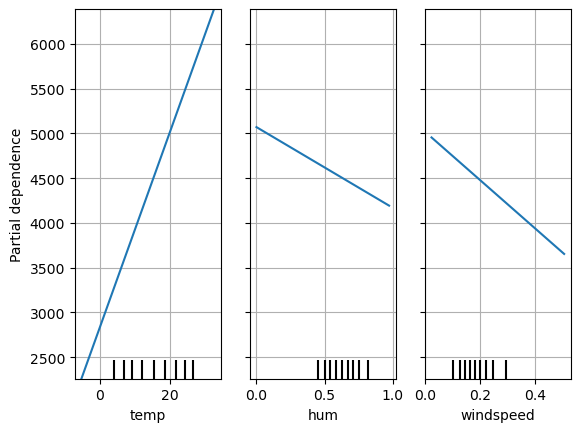

In [6]:
from sklearn.linear_model import LinearRegression

pdp_plot(LinearRegression(), X, y)

R2-score:  0.8003086666446174


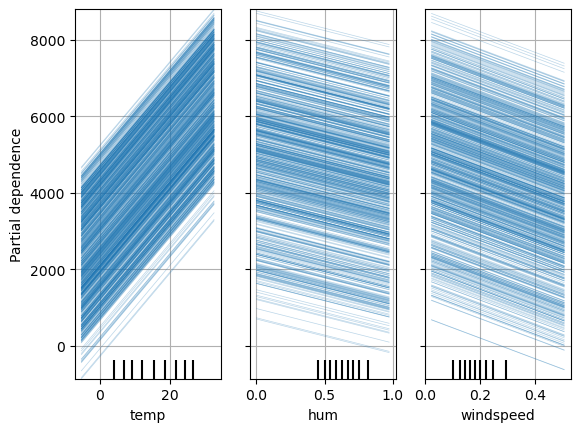

In [7]:
pdp_plot(LinearRegression(), X, y, kind="individual")

R2-score:  0.8003086666446174


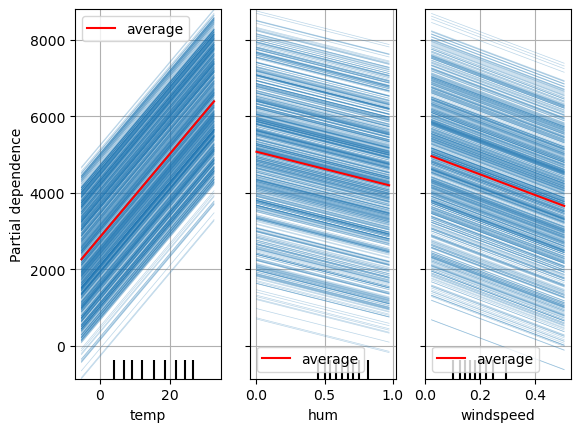

In [8]:
pdp_plot(LinearRegression(), X, y, kind="both")

Q: What is the meaning of the y-axis in the PDP plot?

Q: What is the meaning of the y-axis for classification?

Q: Does it make sense to create a PDP plot for a LinearRegression?

Q: Does it make sense to create a PDP plot for any inherently explainable model?

### PDP for RandomForestRegressor

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\1338738949.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9845133260900834


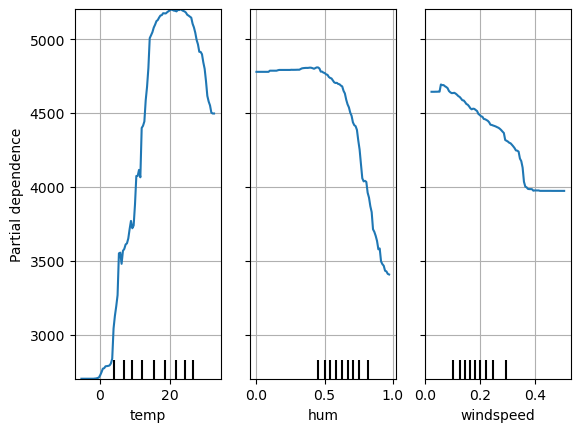

In [9]:
from sklearn.ensemble import RandomForestRegressor

pdp_plot(RandomForestRegressor(), X, y)

### PDP for AdaBoost

C:\Users\sujit\miniconda3\envs\xML\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.8567102147667349


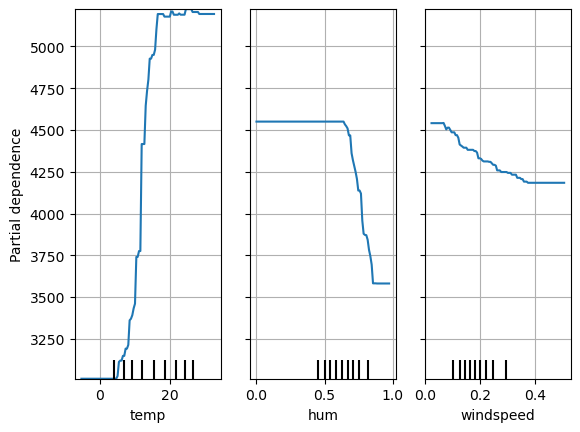

In [10]:
from sklearn.ensemble import AdaBoostRegressor

pdp_plot(AdaBoostRegressor(), X, y)

Q: Does it make sense to use validation data for the averaging?

Q: If you want to explain your model's behaviour, would you use all data / only training data / only validation data?

In [11]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\1338738949.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9821259641644176


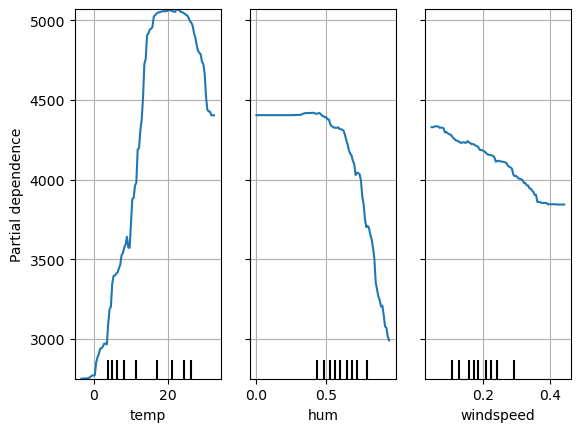

In [12]:
pdp_plot(RandomForestRegressor(), X_train, y_train, X_val)

### Exercise 3.1

Use a `RandomForestRegressor` with `random_state`=1 to predict the number of rented bikes. What is the $\Delta y$ in the last/directly above PDP-plot for the `temp` feature between $20^\circ$ and $0^\circ$? Write a function that returns that exact value.

In [13]:
def ex_3_1() -> float:
    rf_regr = RandomForestRegressor(random_state=1)
    rf_regr.fit(X_train, y_train)
    x_val = X_val.copy()
    
    x_val['temp'] = 20
    temp_high = rf_regr.predict(x_val).mean()
    
    x_val['temp'] = 0
    temp_low = rf_regr.predict(x_val).mean()
    
    return temp_high - temp_low

In [14]:
ex_3_1()

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\632503413.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train)


2354.0546938775506

In [15]:
compare("ex_3_1", ex_3_1)

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\632503413.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train)


Great work!


### Exercise 3.2

In the last/directly above PDP-plot for the `windspeed` feature on the x-axis, on which windspeed value is exactly the 5th vertical line? Write a function that returns that exact value.

In [16]:
from sklearn.inspection import partial_dependence

rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, y_train)
results = partial_dependence(rf_regr, X_val, features=["windspeed"], kind="both", method="brute")

print(results["values"][0])
print(sorted(X_val["windspeed"].to_list()))

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\2473945033.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train)


[0.07277718 0.07551135 0.07824551 0.08097968 0.08371384 0.08644801
 0.08918217 0.09191633 0.0946505  0.09738466 0.10011883 0.10285299
 0.10558715 0.10832132 0.11105548 0.11378965 0.11652381 0.11925798
 0.12199214 0.1247263  0.12746047 0.13019463 0.1329288  0.13566296
 0.13839712 0.14113129 0.14386545 0.14659962 0.14933378 0.15206795
 0.15480211 0.15753627 0.16027044 0.1630046  0.16573877 0.16847293
 0.1712071  0.17394126 0.17667542 0.17940959 0.18214375 0.18487792
 0.18761208 0.19034624 0.19308041 0.19581457 0.19854874 0.2012829
 0.20401707 0.20675123 0.20948539 0.21221956 0.21495372 0.21768789
 0.22042205 0.22315622 0.22589038 0.22862454 0.23135871 0.23409287
 0.23682704 0.2395612  0.24229536 0.24502953 0.24776369 0.25049786
 0.25323202 0.25596619 0.25870035 0.26143451 0.26416868 0.26690284
 0.26963701 0.27237117 0.27510533 0.2778395  0.28057366 0.28330783
 0.28604199 0.28877616 0.29151032 0.29424448 0.29697865 0.29971281
 0.30244698 0.30518114 0.30791531 0.31064947 0.31338363 0.31611

In [17]:
def ex_3_2() -> float:
    return X_val["windspeed"].median()

In [18]:
ex_3_2()

0.185312

In [19]:
compare("ex_3_2", ex_3_2)

Great work!


### PDP for classification

In [20]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


C:\Users\sujit\miniconda3\envs\xML\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.9373177842565598


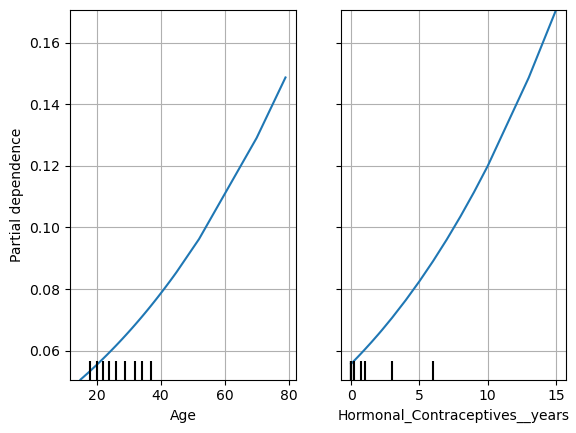

In [21]:
from sklearn.linear_model import LogisticRegression

pdp_plot(LogisticRegression(max_iter=1000), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\1338738949.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


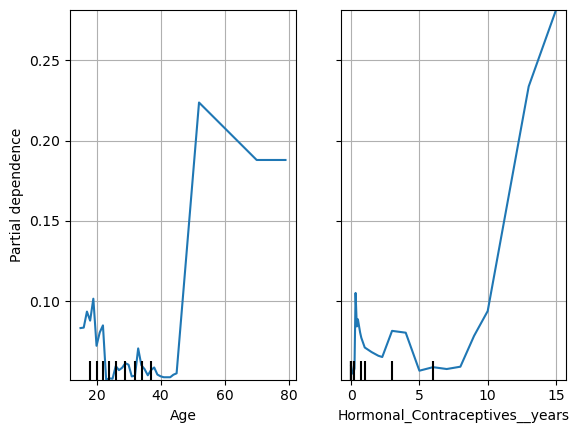

In [22]:
from sklearn.ensemble import RandomForestClassifier
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\1338738949.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


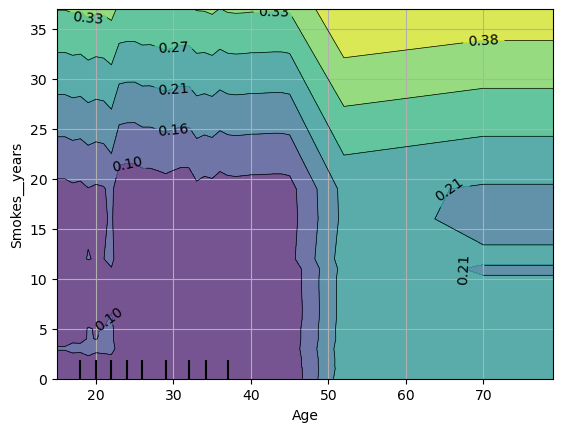

In [23]:
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=[["Age", "Smokes__years"]])

Q: Does this plot imply that smoking increases the cancer probability regardless of age? Take a close look at the upper-left corner

## Individual conditional expectation (ICE) <- local

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\1338738949.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


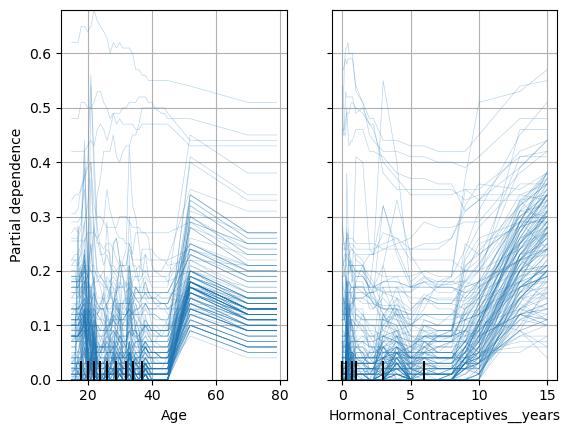

In [24]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="individual")

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\1338738949.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


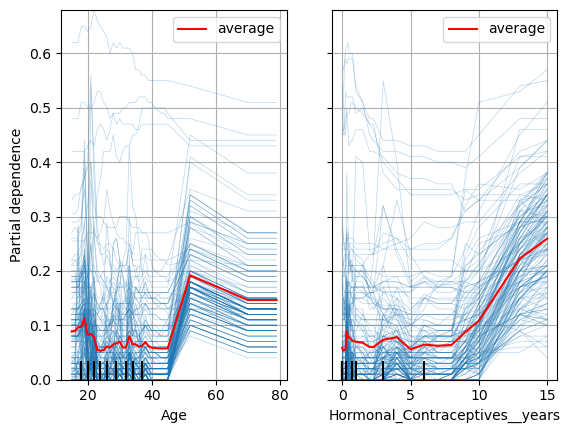

In [25]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="both")

### Exercise 3.3

Use a `RandomForestClassifier(random_state=1)`.
What is the predicted cancer probability with an Age of sixty years according to the datapoint with the highest predicted cancer probability of the validation dataset?
Write a function that returns that value.

In [26]:
def ex_3_3() -> float:
    rf_regr = RandomForestClassifier(random_state=1)
    rf_regr.fit(X_train, y_train)
    
    x_val = X_val.copy()
    x_val['Age'] = 60
    pred_prob_age60 = rf_regr.predict_proba(x_val)
    
    return pred_prob_age60.max(axis=0)[1]

In [27]:
ex_3_3()

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\2442733404.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train)


0.52

In [28]:
compare("ex_3_3", ex_3_3)

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\2442733404.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train)


Great work!


## Accumulated local effects (ALE)

In [29]:
from PyALE import ale # <- This really is more of an m-plot

In [30]:
X,y = bike_data.return_Xy()
regr = RandomForestRegressor(random_state=1)
regr.fit(X,y)

C:\Users\sujit\AppData\Local\Temp\ipykernel_28312\890520154.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X,y)


RandomForestRegressor(random_state=1)

PyALE._ALE_generic:INFO: Continuous feature detected.


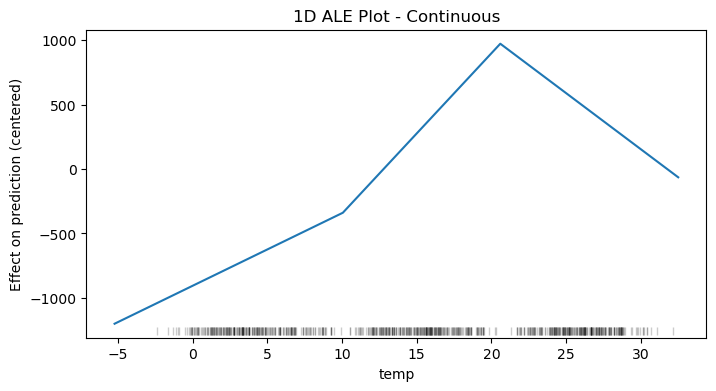

In [31]:
ale_eff = ale(X, regr, ["temp"], grid_size=3, include_CI=False,)

In [32]:
ale_eff

,eff,size
temp,,
-5.220871,-1200.381206,0.0
10.055849,-338.901575,244.0
20.591651,972.902278,244.0
32.498349,-63.894759,243.0


PyALE._ALE_generic:INFO: Continuous feature detected.


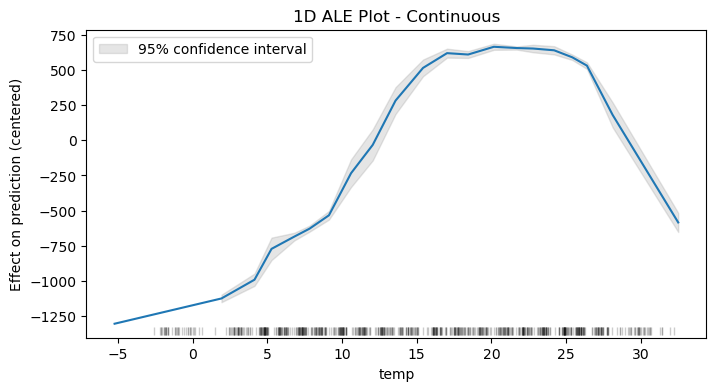

In [33]:
ale_eff = ale(X, regr, ["temp"], grid_size=20, include_CI=True, C=0.95)

In [34]:
ale_eff.reset_index()

,temp,eff,size,lowerCI_95%,upperCI_95%
0,-5.220871,-1304.437601,0.0,NaN,NaN
1,1.931288,-1124.719223,37.0,-1151.469293,-1097.969152
2,4.141651,-991.390612,36.0,-1035.050161,-947.731062
3,5.282623,-771.891422,37.0,-851.772184,-692.010661
4,6.805000,-684.808922,36.0,-712.302558,-657.315286
5,7.823349,-628.386760,37.0,-649.767757,-607.005763
6,9.124356,-533.140371,36.0,-563.883810,-502.396933
7,10.604151,-233.696858,37.0,-332.230836,-135.162880
8,12.053349,-32.454636,36.0,-143.061396,78.152125
9,13.580849,282.745635,37.0,187.392936,378.098333


### Exercise 3.4

For what *lower* temperature is the expectation of the centered effect on the predicted number of rented bikes exactly zero?
(You may use the table directly above)

In [35]:
def ex_3_4() -> float:
    ale_eff_temp = ale_eff.reset_index()
    
    temp_low, eff_low = ale_eff_temp['temp'][8], ale_eff_temp['eff'][8]
    temp_high, eff_high = ale_eff_temp['temp'][9], ale_eff_temp['eff'][9]
    
    slope = (eff_high-eff_low) / (temp_high-temp_low)
    
    return temp_low + (0-eff_low)/slope

In [36]:
ex_3_4()

12.210628229981651

In [37]:
compare("ex_3_4", ex_3_4)

Great work!


### Exercise 3.5 (harder)

Using the above table, what is the 95%-confidence interval of the effect delta when going from `temp=1.931288` to `temp=4.141651`?

*Hint 1*: The 95%-confidence intervall for a normal distribution is at $1.96$ standard deviations

*Hint 2*: https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables

In [38]:
def ex_3_5() -> (float, float):
    ale_eff_temp = ale_eff.reset_index()
    eff_low, lowerci_low, upperci_low = ale_eff_temp['eff'][1], ale_eff_temp['lowerCI_95%'][1], ale_eff_temp['upperCI_95%'][1]
    eff_high, lowerci_high, upperci_high = ale_eff_temp['eff'][2], ale_eff_temp['lowerCI_95%'][2], ale_eff_temp['upperCI_95%'][2]
    
    effect_delta = abs(eff_low - eff_high)
    variance_low = ((upperci_low - lowerci_low) / (2*1.96))**2
    variance_high = ((upperci_high - lowerci_high) / (2*1.96))**2
    std_dev = (variance_low + variance_high)**0.5
    
    return effect_delta - 1.96*std_dev, effect_delta + 1.96*std_dev

In [39]:
ex_3_5()

(82.12585169913822, 184.5313705230839)

In [40]:
compare("ex_3_5", ex_3_5)

Great work!


## Permutation feature importance

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but *how important this feature is for a particular model*.


In [41]:
from sklearn.inspection import permutation_importance

In [42]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, y_train)
regr.score(X_val, y_val)

C:\Users\sujit\miniconda3\envs\xML\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9021025738192169

In [44]:
r = permutation_importance(regr, X_val, y_val, n_repeats=20, random_state=1)

In [45]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<22} | "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

days_since_01_01_2011  | 0.711 +/- 0.047
temp                   | 0.459 +/- 0.034
hum                    | 0.050 +/- 0.010
windspeed              | 0.030 +/- 0.009
weathersit             | 0.016 +/- 0.007
season                 | 0.011 +/- 0.004
mnth                   | 0.008 +/- 0.003
workingday             | 0.007 +/- 0.002


### Exercise 3.6

Using a `GradientBoostingClassifier(random_state=1)` and `permutation_importance(..., n_repeats=20, random_state=1)`. What is the most important feature of in the cervical cancer dataset?
Write a function that returns this column name.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

def ex_3_6() -> str:
    X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)
    
    gb_clf = GradientBoostingClassifier(random_state=1)
    gb_clf.fit(X_train, y_train)
    
    res = permutation_importance(gb_clf, X_val, y_val, n_repeats=20, random_state=1)
    most_imp_feature_ind = res.importances_mean.argmax()
    
    return X_val.columns[most_imp_feature_ind]

In [47]:
ex_3_6()

C:\Users\sujit\miniconda3\envs\xML\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'First_sexual_intercourse'

In [48]:
compare("ex_3_6", ex_3_6)

C:\Users\sujit\miniconda3\envs\xML\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Great work!


Q: Argue why you might question this result?

Q: Repeat `ex_3_6` with a `RandomForestClassifier` instead. What is now the result?

In [49]:
from ce3_compare import scores

In [50]:
scores

{'ex_3_1': True,
 'ex_3_2': True,
 'ex_3_3': True,
 'ex_3_4': True,
 'ex_3_5': True,
 'ex_3_6': True}

In [51]:
write_submission_txt()

In [52]:
grade("ce3_Sujit_Debnath.txt")

'100.0% are correct'